# Persistent Homology Project

## Introduction
Persistent Homology is a technique that has been used to demonstrate that an image of a black hole does indeed have a hole.[1] https://twitter.com/mitchelleithun/status/1116443279992729602

Can we detect whether a collection of points in 3-dimensional space has a crater? To answer this question, we use a point cloud of a famous meteor crater found in Arizona. We want to see if the persistent homology can detect the crater as a feature of the point cloud data by analyzing persistence diagrams generated from a Vietoris-Rips filtration of a sample of LiDAR point cloud data. We generate three samples of 1000 points each from the LiDAR data and compare the resulting persistence diagrams.

LiDAR data of the Barringer Crater in Arizona is accessible by following the link https://www.lpi.usra.edu/publications/books/barringer_crater_guidebook/LiDAR/ and downloading the file called `points.las`. A python package called `laspy` is used to convert the point cloud data into a numpy array.

Additionally, a map of the area in question can be located at http://opentopo.sdsc.edu/lidarDataset?opentopoID=OTLAS.112011.26912.3

The persistence diagrams are calculated and displayed using a python library called `dionysus`.


In [1]:
# !pip install laspy

### Import Data
The data for the point cloud of the Barringer Crater in Arizona can be found at https://www.lpi.usra.edu/publications/books/barringer_crater_guidebook/LiDAR/ as a file called `points.las`.



In [2]:
# from laspy.file import File
# import numpy as np

# # Get file
# las_file = "points.las"
# # Read file
# inFile = File(las_file, mode='r')
# data = inFile.points

# # inFile.close() # this must be placed at the very end after all calculations have been made using data

### Sampling the LiDAR Point Cloud of Meteor Crater
Since the `.las` file contains over a million data points and takes up nearly 4GB of hard drive space, it is too cumbersome to work with directly in this Jupyter notebook. Thus, sample point clouds containing 1000 points each were generated offline on a local machine, saved to a `.npy` file, and uploaded to the folder containing this notebook.

The commented code found below was used to generate the samples offline. Note that the coordinates have been massaged so that all points lie within the unit cube.

In [3]:
# import random

# head = inFile.header
# max_x, max_y, max_z = head.max
# min_x, min_y, min_z = head.min

# range_x = (max_x-min_x)
# range_y = (max_y-min_y)
# range_z = (max_z-min_z)

# n = len(data)
# num_points_sampled = 1000
# xs = np.zeros(num_points_sampled)
# ys = np.zeros(num_points_sampled)
# zs = np.zeros(num_points_sampled)

# for i in range(3):
#     # Get list of random indices between 0 and len(data)
#     rand_indices = random.sample(range(n+1), num_points_sampled)
#     for c, idx in enumerate(rand_indices):
#         xs[c] = (data[idx][0][0]/100 - min_x)/(max_x-min_x)
#         ys[c] = (data[idx][0][1]/100 - min_y)/(max_y-min_y)
#         zs[c] = (data[idx][0][2]/100 - min_z)/(max_z-min_z)
#     np.save('sample_points_{}'.format(i), np.stack((xs,ys,zs), axis=-1))

#### Importing the sample data

In [4]:
import numpy as np

point_cloud_0 = np.load('sample_points_0.npy')
point_cloud_1 = np.load('sample_points_1.npy')
point_cloud_2 = np.load('sample_points_2.npy')

point_cloud_test = np.load('pc1.npy')

#### Plotting a test sample of 10 points

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

xs = point_cloud_test.transpose()[0]
ys = point_cloud_test.transpose()[1]
zs = point_cloud_test.transpose()[2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c='r', marker='.')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

<Figure size 640x480 with 1 Axes>

# Visualizing Homology via Persistence Diagrams and Barcodes
The following code, created by Mark Leadingham, will produce barcodes and persistence diagrams.

In [6]:
# Code by Mark Leadingham
def better_plots(dgms,deg):
    new_death=0
    for degree, dgm in enumerate(dgms):
        for point in dgm:
            if point.death != float('inf'):
                if point.death>new_death:
                    new_death=float(point.death)
    new_death=new_death*1.25
    #Plot the barcodes
#     fig=plt.figure()
    
    patches = []
    iterate=0
    for degree, dgm in enumerate(dgms):
        if degree>=deg-1:
            break
        fig=plt.figure(degree)
        for point in dgm:
            if float(point.death) != float('inf'): 
                plt.plot([point.birth,point.death], [iterate,iterate])
            else:
                plt.plot([point.birth, new_death], [iterate,iterate])
#                 arrow = mpatches.Arrow((iterate, point.birth), (iterate, point.death))
#                 patches.append(arrow)
            iterate+=1
        plt.title('Degree: '+str(degree))
        plt.xlabel('Parameter, r')
        plt.show()
    
    for degree, dgm in enumerate(dgms):
        if degree>=deg-1:
            break
        fig2=plt.figure(degree)
        for point in dgm:
            #if degree==2:
                #print(point.birth, point.death)
            if float(point.death) != float('inf'): 
                plt.scatter(point.birth,point.death, figure=fig2)
            else:
                plt.scatter(point.birth, new_death, figure=fig2)
        maxe=new_death
            
        plt.plot([0,maxe],[0,maxe], figure=fig2)
        plt.title('Degree: '+str(degree))
        plt.show()

#### Generating Persistence Diagrams

To generate diagrams that are meaningful for our question, we need to omit points which lie below a threshold elevation. Otherwise, we will not see a "hole" develop in the diagram for $H_1$ marked 'Degree: 1' below. 

In [7]:
import dionysus as dio
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist

elev_thresh = .64
skeleton_degree = 3
max_parameter = 1.75

##### Point Cloud 0

In [8]:
# Number of points in the sample satisfying the condition
len(point_cloud_0[point_cloud_0[:,2]>elev_thresh])

120

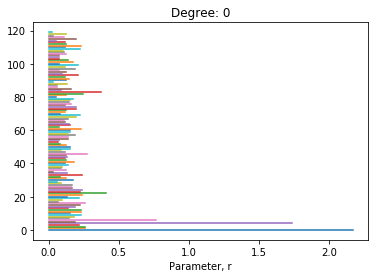

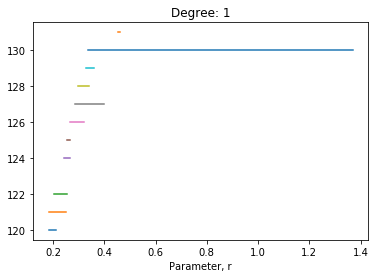

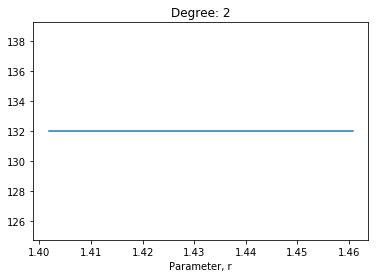

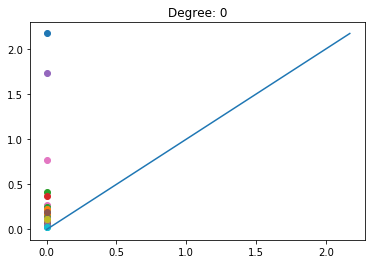

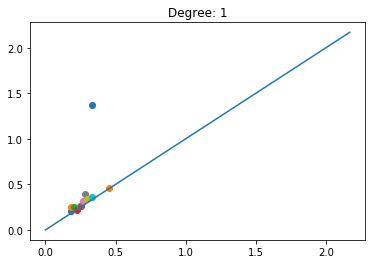

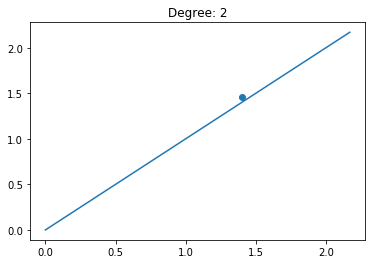

In [9]:
# Use only the data points that satisfy the elevation threshold
compressed_M = squareform(pdist(point_cloud_0[point_cloud_0[:,2]>elev_thresh],'euclidean'))
fil_rips = dio.fill_rips(compressed_M, skeleton_degree, max_parameter)
h = dio.homology_persistence(fil_rips)
dgms_0 = dio.init_diagrams(h,fil_rips)

better_plots(dgms_0,4)

#### Interpreting the diagrams
The barcodes show how long each simplex of the given degree exists before being subsumed by a simplex of higher degree.

0-simplices, shown in the Degree 0 plots, are points (or vertices) <br>
1-simplices, shown in the Degree 1 plots, are edges between points <br>
2-simplices, shown in the Degree 2 plots, are cycles

The horizontal axis of the persistence diagrams is the radius where a simplex is "born" and the vertical axis is the radius where a simplex "dies", or is subsumed by a larger simplex.
Points representing simplices very close the line have very short lifetimes while points farther away persist for bigger radii.
Short lifetimes are likely to be noise while long lifetimes are more likely to be signal.

##### Point Cloud 1

In [10]:
# Number of points in the sample satisfying the condition
len(point_cloud_1[point_cloud_1[:,2]>elev_thresh])

109

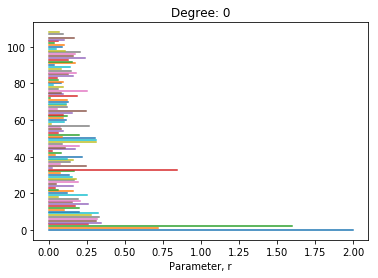

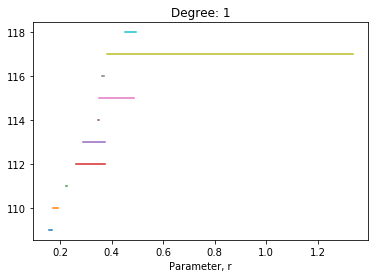

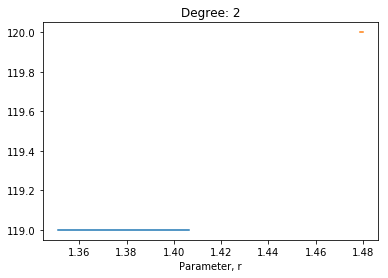

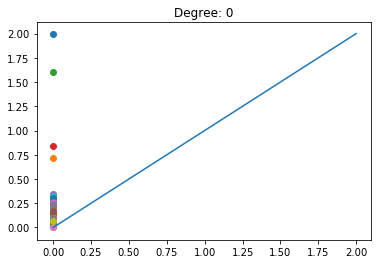

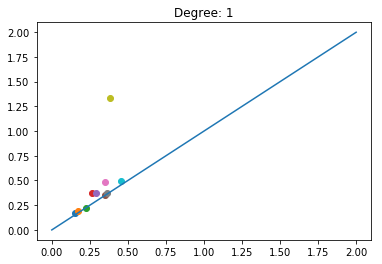

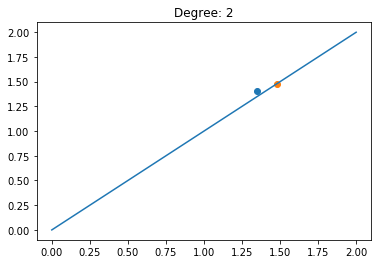

In [11]:
# Use only the data points that satisfy the elevation threshold
compressed_M = squareform(pdist(point_cloud_1[point_cloud_1[:,2]>elev_thresh],'euclidean'))
fil_rips = dio.fill_rips(compressed_M, skeleton_degree, max_parameter)
h = dio.homology_persistence(fil_rips)
dgms_1 = dio.init_diagrams(h,fil_rips)

better_plots(dgms_1,4)

##### Point Cloud 2

In [12]:
# Number of points in the sample satisfying the condition
len(point_cloud_2[point_cloud_2[:,2]>elev_thresh])

91

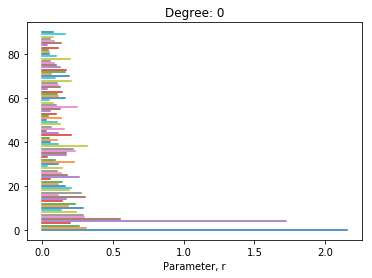

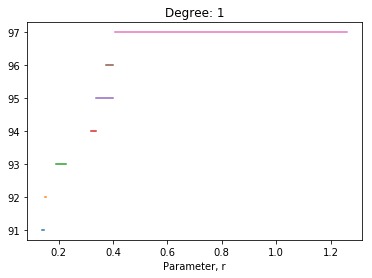

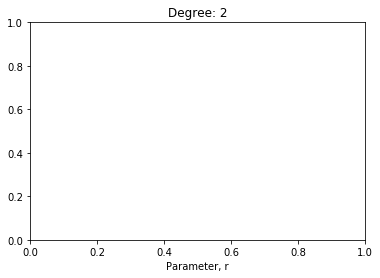

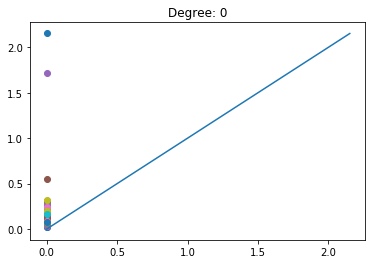

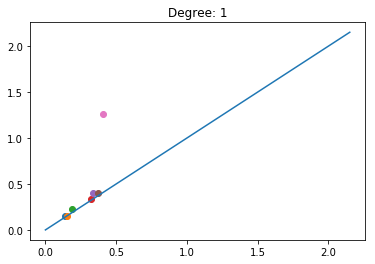

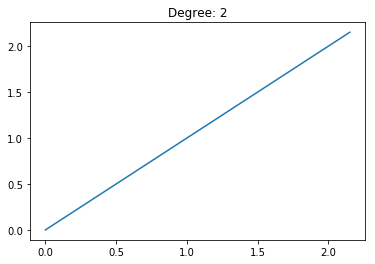

In [13]:
# Use only the data points that satisfy the elevation threshold
compressed_M = squareform(pdist(point_cloud_2[point_cloud_2[:,2]>elev_thresh],'euclidean'))
fil_rips = dio.fill_rips(compressed_M, skeleton_degree, max_parameter)
h = dio.homology_persistence(fil_rips)
dgms_2 = dio.init_diagrams(h,fil_rips)

better_plots(dgms_2,4)

For the degree 1 persistence diagrams, notice how there is a point that comes into existence somewhere between 0.25 and 0.50 in all three samples. This represents the presence of a hole that persists for very large values of the radius. This is our crater.

## Comparing Persistence Diagrams
We compare the 3 persistence diagrams for $H_1$ above using the Bottleneck distance. This provides us a measure for how "unlike" two diagrams are. We convert this into a measure of similarity where larger values mean that the two diagrams are more similar.

In [14]:
BD = np.zeros((3,3))
h_num = 1
diagrams = [dgms_0[h_num], dgms_1[h_num], dgms_2[h_num]]

for i in range(3):
    for j in range(3):
        BD[i][j] = dio.bottleneck_distance(diagrams[i],diagrams[j], delta=.000001)

print('\nBottleneck Distance\n', BD)


Bottleneck Distance
 [[0.         0.06753352 0.11217093]
 [0.06753349 0.         0.0783736 ]
 [0.11217099 0.07837361 0.        ]]


In [15]:
def similarity_from_dissimilarity(M):
    for i in range(len(M)):
        for j in range(len(M)):
            if i!=j:
                M[i][j] = 1/M[i][j]
    return M

print('\nBottleneck similarity\n', similarity_from_dissimilarity(BD))


Bottleneck similarity
 [[ 0.         14.80746255  8.91496539]
 [14.80746745  0.         12.75939921]
 [ 8.91496065 12.75939679  0.        ]]


Thus, we can compare how similar these samples are in relation to each pair's similarity score. One reason for doing this is that we want to know how many points we need to sample in order to produce diagrams that are reliable.
Sampling with fewer points will likely lead to more variation in the diagrams. And sampling with more points will lead to less variation in the diagrams.
But, taking a large sample of points imposes a great cost in calculating these diagrams. A thorough understanding of the minimum number of points needed to provide analysis that "close enough" is desired. 

So, it appears that we can detect a large crater in point cloud data of a digital elevation model with only around 100 points sampled from a data set of over a million points.